Total images in dataset: 8587


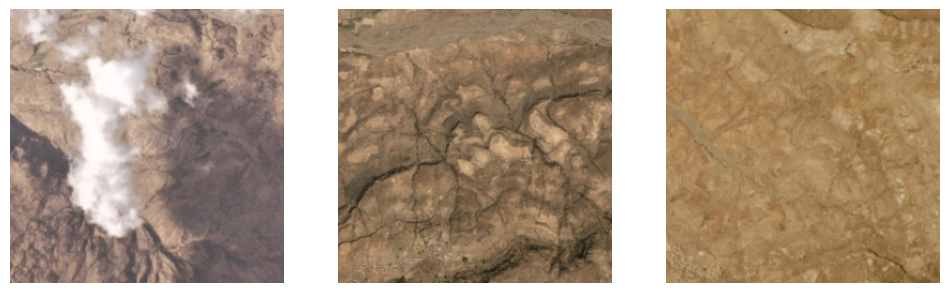

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Load Dataset
dataset_path = "C:\\Users\\padma\\Desktop\\satellite dataset\\archive\\ethiopia_archive\\images"  # Path to the dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Display sample images
print(f"Total images in dataset: {len(image_files)}")

# Display 3 random images
plt.figure(figsize=(12, 4))
for i in range(3):
    img_path = os.path.join(dataset_path, image_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [2]:
# Step 2: Image Preprocessing
def preprocess_images(image_files, dataset_path, resize_dim=(64, 64)):
    images = []
    for file_name in tqdm(image_files, desc="Preprocessing Images"):
        img_path = os.path.join(dataset_path, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, resize_dim)  # Resize to 64x64
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
    return np.array(images)

# Preprocess all images
resize_dim = (64, 64)
images = preprocess_images(image_files, dataset_path, resize_dim)
print(f"Preprocessed images shape: {images.shape}")

Preprocessing Images: 100%|████████████████████████████████████████████████████████| 8587/8587 [02:05<00:00, 68.17it/s]


Preprocessed images shape: (8587, 64, 64, 3)


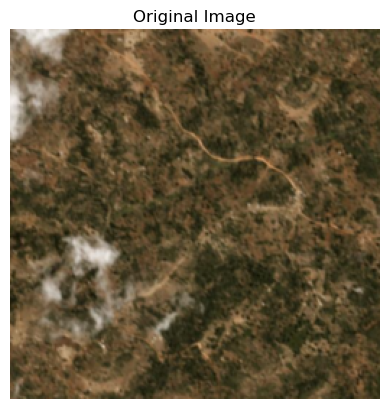

C:\Users\padma\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\padma\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet-50 Deep Feature Vector Shape: (2048,)


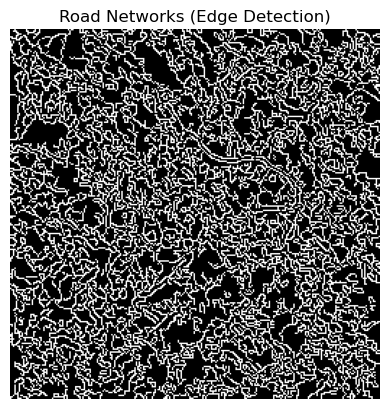

Texture Contrast (Roof Type): [[100.85396752]]
Brightness (Lighting Sources): 77.89872741699219


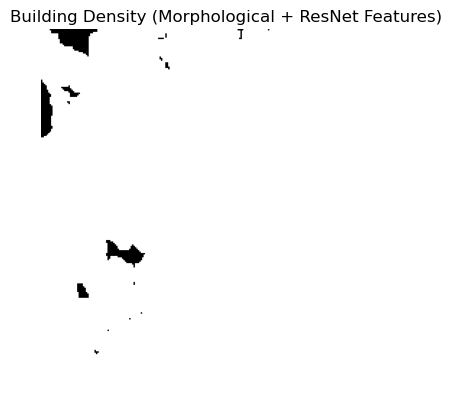

Building Density: 64605.0, Deep Feature Score: 0.0
Vegetation Cover: 0.0, Deep Feature Score: 0.03421251103281975
Water Bodies Cover: 0.0, Deep Feature Score: 0.02123299427330494


In [3]:
# Step 3 : Feature Extraction
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from skimage.feature import graycomatrix, graycoprops

# Load a sample satellite image
image_path = r"C:\Users\padma\Desktop\satellite dataset\archive\ethiopia_archive\images\5.59568261612_38.263675399896016_5.59568261612_38.2936192427.png"
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Image not found or unable to load. Check the path: {image_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Display the original image
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Load Pre-trained ResNet-50 Model (Removing Final Layer)
    resnet50 = models.resnet50(pretrained=True)
    resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])  # Remove final classification layer
    resnet50.eval()  # Set the model to evaluation mode

    # Image Preprocessing for ResNet-50
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL image
        transforms.Resize((224, 224)),  # Resize to ResNet-50 input size
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ])

    # Preprocess the image and extract features using ResNet-50
    img_resnet = preprocess(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        deep_features = resnet50(img_resnet)  # Extract 2048D feature vector

    deep_features = deep_features.flatten().numpy()  # Convert to NumPy array
    print(f"ResNet-50 Deep Feature Vector Shape: {deep_features.shape}")  # Should be (2048,)

    # Step 1: Traditional & Deep Learning Techniques
    # Step 1.1: Road Networks (Edge Detection)
    def detect_roads(image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, threshold1=50, threshold2=150)
        return edges

    roads = detect_roads(img)
    plt.imshow(roads, cmap='gray')
    plt.title("Road Networks (Edge Detection)")
    plt.axis('off')
    plt.show()

    # Step 1.2: Roof Type (Texture Analysis)
    def analyze_texture(image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')
        return contrast

    texture = analyze_texture(img)
    print(f"Texture Contrast (Roof Type): {texture}")

    # Step 1.3: Lighting Sources (Brightness Analysis)
    def analyze_brightness(image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        brightness = np.mean(gray)
        return brightness

    brightness = analyze_brightness(img)
    print(f"Brightness (Lighting Sources): {brightness}")

    # Step 1.4: Building Density (Using ResNet Features & Morphological Operations)
    def detect_building_density(image, deep_features):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((5, 5), np.uint8)
        dilated = cv2.dilate(binary, kernel, iterations=1)
        building_density = np.sum(dilated) / 255  # Count white pixels
        deep_building_score = deep_features[0]  # First feature from ResNet embedding
        return dilated, building_density, deep_building_score

    building_mask, building_density, deep_building_score = detect_building_density(img, deep_features)
    plt.imshow(building_mask, cmap='gray')
    plt.title("Building Density (Morphological + ResNet Features)")
    plt.axis('off')
    plt.show()
    print(f"Building Density: {building_density}, Deep Feature Score: {deep_building_score}")

    # Step 1.5: Vegetation Cover (NDVI + ResNet)
    def detect_vegetation(image, deep_features):
        image = image.astype(np.float32)
        red = image[:, :, 0]
        nir = image[:, :, 1]  # Using Green channel as NIR proxy
        ndvi = (nir - red) / (nir + red + 1e-10)
        vegetation_mask = ndvi > 0.2
        vegetation_cover = np.sum(vegetation_mask) / (img.shape[0] * img.shape[1])
        deep_veg_score = deep_features[1]  # Second feature from ResNet embedding
        return vegetation_mask, vegetation_cover, deep_veg_score

    vegetation_mask, vegetation_cover, deep_veg_score = detect_vegetation(img, deep_features)
    #plt.imshow(vegetation_mask, cmap='gray')
    #plt.title("Vegetation Cover (NDVI + ResNet Features)")
    #plt.axis('off')
    #plt.show()
    print(f"Vegetation Cover: {vegetation_cover}, Deep Feature Score: {deep_veg_score}")

    # Step 1.6: Water Bodies (Color Thresholding + ResNet)
    def detect_water_bodies(image, deep_features):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_water = np.array([90, 50, 50])
        upper_water = np.array([130, 255, 255])
        mask = cv2.inRange(hsv, lower_water, upper_water)
        water_cover = np.sum(mask) / 255  # Count white pixels
        deep_water_score = deep_features[2]  # Third feature from ResNet embedding
        return mask, water_cover, deep_water_score

    water_mask, water_cover, deep_water_score = detect_water_bodies(img, deep_features)
    #plt.imshow(water_mask, cmap='gray')
   # plt.title("Water Bodies (HSV + ResNet Features)")
    #plt.axis('off')
   # plt.show()
    print(f"Water Bodies Cover: {water_cover}, Deep Feature Score: {deep_water_score}")

In [4]:
#Wealth index calculation
def extract_features(image):
    """
    Extract all features from an image:
    - Road networks
    - Roof type (texture contrast)
    - Brightness
    - Building density
    - Vegetation cover
    - Water bodies
    """
    # Step 1.1: Road Networks (Edge Detection)
    roads = detect_roads(image)

    # Step 1.2: Roof Type (Texture Analysis)
    texture = analyze_texture(image)

    # Step 1.3: Lighting Sources (Brightness Analysis)
    brightness = analyze_brightness(image)

    # Step 1.4: Building Density (Morphological Operations)
    building_mask, building_density, _ = detect_building_density(image, np.zeros(2048))  # Dummy deep features

    # Step 1.5: Vegetation Cover (NDVI Calculation)
    vegetation_mask, vegetation_cover, _ = detect_vegetation(image, np.zeros(2048))  # Dummy deep features

    # Step 1.6: Water Bodies (Color Thresholding in HSV Space)
    water_mask, water_cover, _ = detect_water_bodies(image, np.zeros(2048))  # Dummy deep features

    # Return all features as a tuple
    return roads, texture, brightness, building_density, vegetation_cover, water_cover

In [5]:
import numpy as np

def calculate_wealth_index(roads, texture, brightness, building_density, vegetation_cover, water_cover):
    """
    Calculate the wealth index based on the extracted features.
    Each feature is normalized and weighted to contribute to the final index.
    """
    # Normalize features to a scale of 0 to 1
    roads_score = np.mean(roads) / 255.0  # Normalize road detection output (0 to 1)
    texture_score = texture[0][0] / 100.0  # Normalize texture contrast (0 to 1)
    brightness_score = brightness / 255.0  # Normalize brightness (0 to 1)
    building_score = building_density / (64 * 64)  # Normalize building density (0 to 1)
    vegetation_score = vegetation_cover  # Already normalized (0 to 1)
    water_score = water_cover / (64 * 64)  # Normalize water cover (0 to 1)

    # Adjust weights to ensure realistic contributions
    weights = {
        'roads': 0.2,  # Roads contribute 20%
        'texture': 0.1,  # Texture contributes 10%
        'brightness': 0.1,  # Brightness contributes 10%
        'building_density': 0.3,  # Building density contributes 30%
        'vegetation_cover': 0.2,  # Vegetation contributes 20%
        'water_cover': 0.1  # Water contributes 10%
    }

    # Calculate weighted sum
    wealth_index = (
        weights['roads'] * roads_score +
        weights['texture'] * texture_score +
        weights['brightness'] * brightness_score +
        weights['building_density'] * building_score +
        weights['vegetation_cover'] * vegetation_score +
        weights['water_cover'] * water_score
    ) * 100  # Scale to 1-100

    # Clip the wealth index to ensure it stays within the range [1, 100]
    return np.clip(wealth_index, 1, 100)

# Example usage
roads = np.zeros((64, 64), dtype=np.uint8)  # Example: No roads
texture = np.array([[50]])  # Example: Moderate texture contrast
brightness = 128  # Example: Moderate brightness
building_density = 1000  # Example: Some buildings
vegetation_cover = 0.5  # Example: Moderate vegetation
water_cover = 500  # Example: Some water bodies

wealth_index = calculate_wealth_index(roads, texture, brightness, building_density, vegetation_cover, water_cover)
print(f"Wealth Index: {wealth_index}")

Wealth Index: 28.564529718137255


In [6]:
def classify_wealth_index(wealth_index):
    """
    Classify the wealth index into one of five classes.
    """
    if 1 <= wealth_index < 20:
        return "Very Poor"
    elif 20 <= wealth_index < 40:
        return "Poor"
    elif 40 <= wealth_index < 60:
        return "Moderate"
    elif 60 <= wealth_index < 80:
        return "Wealthy"
    elif 80 <= wealth_index <= 100:
        return "Very Wealthy"
    else:
        return "Unknown"

# Example usage
wealth_class = classify_wealth_index(wealth_index)
print(f"Wealth Index: {wealth_index}, Class: {wealth_class}")

Wealth Index: 28.564529718137255, Class: Poor


In [7]:
#Training CNN model
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Prepare dataset (X: images, y: wealth index)
X = images  # Preprocessed images from Step 2 (already normalized to [0, 1])

# Convert images back to uint8 for feature extraction
X_uint8 = [(img * 255).astype(np.uint8) for img in X]

# Calculate wealth index for each image
y = np.array([calculate_wealth_index(*extract_features(img)) for img in X_uint8])

# Normalize wealth index to 0-1 for training
y_normalized = y / 100.0

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=42)

# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output wealth index (normalized to 0-1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save the model
model.save("wealth_index_model.h5")

C:\Users\padma\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0264 - mae: 0.1104 - val_loss: 0.0032 - val_mae: 0.0414
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0039 - mae: 0.0482 - val_loss: 0.0026 - val_mae: 0.0393
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0030 - mae: 0.0418 - val_loss: 0.0034 - val_mae: 0.0429
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0024 - mae: 0.0372 - val_loss: 0.0014 - val_mae: 0.0275
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0019 - mae: 0.0333 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 0.0014 - val_mae: 0.0272
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0013 - mae: 0.0270 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 8.6799e-04 - mae: 0.0219 - val_loss: 8.4897e-04 - val_mae: 0.0220
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.9141e-04 - mae: 0.0223
Test Loss: 0.0009, Test MAE: 0.0219
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Accuracy: 90.80%

Detailed Classification Report:
              precision    recall  f1-score   support

    Moderate       0.92      0.91      0.91       537
        Poor       0.75      0.89      0.81       100
   Very Poor       0.89      0.98      0.93        51
Very Wealthy       0.90      0.99      0.94       484
     Wealthy       0.95      0.83      0.89       546

    accuracy                           0.91      1718
   macro avg       0.88      0.92      0.90      1718
weighted avg       0.91      0.91      0.91      1718


Confusion Matrix:
[[488  29   0   0  20]
 [  5  89   6   0   0]
 [  0   1  50   0   0]
 [  0   0   0 481   3]
 [ 39   0   0  55 452]]


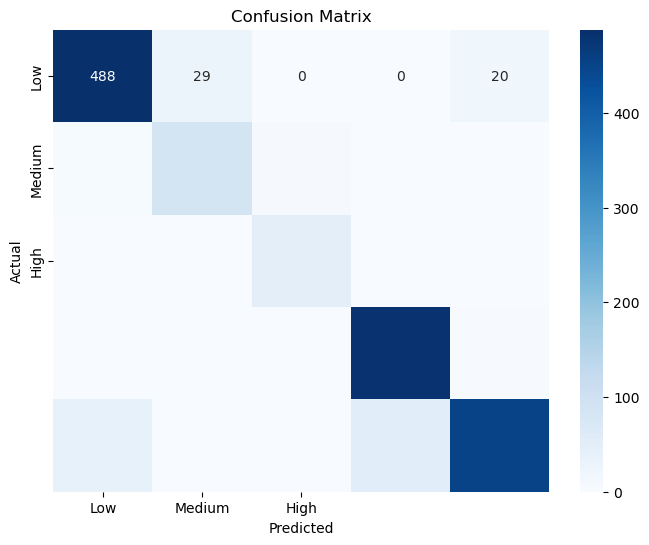


Regression Metrics:
Mean Squared Error: 9.39
Root Mean Squared Error: 3.06
R-squared: 0.98


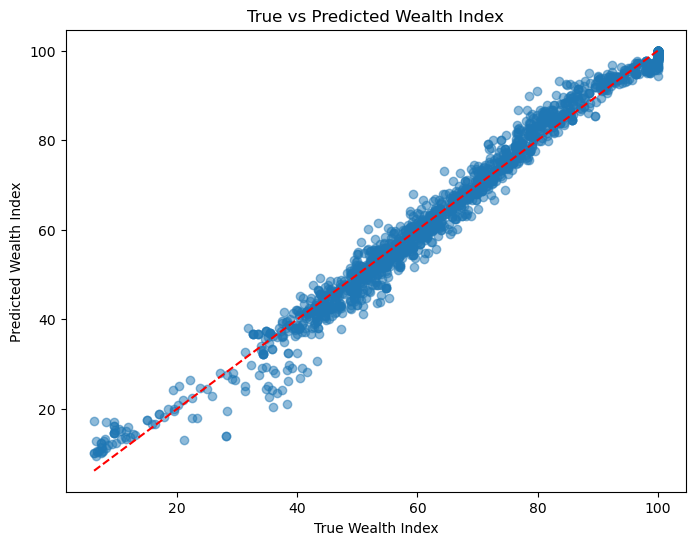

In [8]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict wealth index for test images
y_pred = model.predict(X_test) * 100  # Rescale to 1-100

# Convert true values back to 0-100 scale
y_true = y_test * 100

# Calculate classification accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true and predicted classes
y_true_classes = [classify_wealth_index(true) for true in y_true]
y_pred_classes = [classify_wealth_index(pred[0]) for pred in y_pred]

# Calculate accuracy percentage
accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100
print(f"\nAccuracy: {accuracy:.2f}%")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

# Visual representation of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'], 
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Additional regression metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Optional: Plot predicted vs true values for regression visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--r')
plt.xlabel('True Wealth Index')
plt.ylabel('Predicted Wealth Index')
plt.title('True vs Predicted Wealth Index')
plt.show()